In [242]:
!pwd
#!ls

/Nancy/mrayko/viruses/size_estimation_NB


Get refseq fasta, split to train and test

In [168]:
refseq_viruses = "/Nancy/mrayko/db/refseq_viruses/total.gbff" #viral.1.genomic.gbff"  
from Bio import SeqIO
genomes={} # RefSeq genome: [RefSeq proteins]
genomes_len={} # RefSeq genome: [Genome length, genome description]
proteins_to_genomes={} # RefSeq protein: [RefSeq genome]

for record in SeqIO.parse(open(refseq_viruses),"genbank"):
  if len(record) >= 5000: # We keep only viruses > 5 kb
    genomes_len[record.id] = [len(record), record.description]
    genomes[record.id] = []
    #print(record.id)
   #print(record.name)
    #print(record.description)
    for feature in record.features:
        if feature.type == "CDS":
          #print (feature.qualifiers.keys())
          if "protein_id" in feature.qualifiers:
            genomes[record.id].append(feature.qualifiers["protein_id"][0])
            proteins_to_genomes[feature.qualifiers["protein_id"][0]] = record.id
   #print(record.features[13].type)
   #print(record.features[13].qualifiers)
   #print(record.features[13].qualifiers["protein_id"])

   #genomes_len[record.id] = [len(record), record.description.split(",")[0].split(' ', 1)[1]]
#for i in genomes:
 #   print (i)
  #  print (len(genomes[i]))
#print(genomes)





In [293]:
import pickle
#with open('viral_genomes_over5kb.pkl', 'wb') as f:
 #   pickle.dump(genomes, f)

#with open('viral_genomes_len_over5kb.pkl', 'wb') as f:
 #   pickle.dump(genomes_len, f)

#with open('proteins_to_genomes_over5kb.pkl', 'wb') as f:
 #   pickle.dump(proteins_to_genomes, f)
    

with open('viral_genomes_over5kb.pkl', 'rb') as f:
    genomes = pickle.load(f)

with open('viral_genomes_len_over5kb.pkl', 'rb') as f:
    genomes_len = pickle.load(f)

with open('proteins_to_genomes_over5kb.pkl', 'rb') as f:
    pickle.load(f)
    
    #print (data_new["Streptococcus thermophilus DSM"][-1])

print (len(genomes))


10544


In [ ]:
# Split to test (30%) and train(70%):

In [294]:
import random
random.seed(a=25)
keys = list(genomes.keys())
s = set(random.sample(keys, round(len(genomes)*0.3)))

In [295]:
train={}
test={}
for i in genomes:
    if i in s:
        test[i] = genomes[i]
    else:
        train[i] = genomes[i]

In [243]:
print(len(train))
print(len(test))

4091
1754


In [215]:
proteins= []
for i in train:
    #if len(train[i]) == 1:
      #print (len(train[i]))
      #print (i)
    proteins+=train[i]

In [219]:
# Get list of proteins for train dataset
with open('train_proteins_over5kb.txt', 'w') as f:
    for item in proteins:
        f.write("%s\n" % item)

In [228]:
# Get fasta for train proteins

#!python /Nancy/mrayko/tmp_py_scripts/get_fasta_from_names.py --l train_proteins_over5kb.txt --f /Nancy/mrayko/db/refseq_viruses/total.protein.fa > train_proteins_over5kb.fa
! samtools faidx  /Nancy/mrayko/db/refseq_viruses/total.protein.fa 
! xargs samtools faidx  /Nancy/mrayko/db/refseq_viruses/total.protein.fa  < train_proteins_over5kb.txt > train_proteins_over5kb.fa

!grep ">" train_proteins_over5kb.fa  | wc -l

215579


In [229]:
counter=0
for i in train:
    counter+=len(train[i])
print (counter)

215579


In [232]:
!makeblastdb -in train_proteins_over5kb.fa -dbtype prot -out train_proteins_over5kb



Building a new DB, current time: 03/26/2019 12:12:19
New DB name:   /Nancy/mrayko/viruses/size_estimation_NB/train_proteins_over5kb
New DB title:  train_proteins_over5kb.fa
Sequence type: Protein
Deleted existing Protein BLAST database named /Nancy/mrayko/viruses/size_estimation_NB/train_proteins_over5kb
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 215579 sequences in 17.189 seconds.


In [251]:
# Делим тестовый датасет на полные и неполные.
print(len(test))
test_keys = list(test.keys())
s = set(random.sample(test_keys, round(len(test)*0.5)))
print(len(s))

test_pos={}
test_neg={}
for i in test:
    if i in s:
        test_pos[i] = test[i]
    else:
        test_neg[i] = test[i]

print ("Positive: ",len(test_pos))
print ("Negative: ",len(test_neg))

1754
877
Positive:  877
Negative:  877


In [253]:
# Получаем фасту для полных и неполных:
with open('test_positive.txt', 'w') as f:
    for item in test_pos:
        f.write("%s\n" % item)

with open('test_negative.txt', 'w') as f:
    for item in test_neg:
        f.write("%s\n" % item)

In [269]:
! samtools faidx  /Nancy/mrayko/db/refseq_viruses/total.genomic.fa
! xargs samtools faidx  /Nancy/mrayko/db/refseq_viruses/total.genomic.fa  < test_positive.txt > test_positive.fa
! xargs samtools faidx  /Nancy/mrayko/db/refseq_viruses/total.genomic.fa  < test_negative.txt > test_negative.fa 

In [274]:
#Обрезаем неполные пополам:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
handle = open("test_negative.fa", 'r')
records = list(SeqIO.parse(handle, "fasta"))


with open("test_negative_cut.fa", 'w') as outfile:
  for record in records:
    cut_seq = str(record.seq)[:len(record)//2]
    cut_record = SeqRecord(Seq(cut_seq, record.seq.alphabet),
            id=record.id, name=record.name,
            description=record.description)
    SeqIO.write(cut_record, outfile, "fasta")


In [275]:
# Предсказываем гены.
!prodigal -p meta -a test_positive_proteins.fa -o test_positive_prodigal.out -q -i test_positive.fa
!prodigal -p meta -a test_negative_cut_proteins.fa -o test_negative_cut_prodigal.out -q -i test_negative_cut.fa

In [ ]:
#Бластим.
!blastp -db train_proteins_over5kb -query test_positive_proteins.fa -out test_positive_blast_out.txt  -outfmt 5  -evalue 0.000001 -max_target_seqs 5 -num_threads 20
!blastp -db train_proteins_over5kb -query test_negative_cut_proteins.fa -out test_negative_cut_blast_out.txt  -outfmt 5  -evalue 0.000001 -max_target_seqs 5 -num_threads 20

In [276]:
ls

0.0.txt                          test_positive.fa
1.fa                             test_positive.txt
1_prodigal.out                   test_positive_prodigal.out
1_proteins.fa                    test_positive_proteins.fa
2.fa                             test_proteins.fa
3.fa                             test_result.txt
3_cut.fa                         test_viruses.fa
3_test.fa                        test_viruses.txt
3_test_prodigal.out              test_viruses_prodigal.out
3_test_proteins.fa               train_proteins.fa
5_blast_out.txt                  train_proteins.phr
5_test.fa                        train_proteins.pin
5_test_prodigal.out              train_proteins.psq
5_test_proteins.fa               train_proteins.txt
Get_size_estimation_Bayes.ipynb  train_proteins_over5kb.fa
blast_out.txt                    train_proteins_over5kb.phr
proteins_to_genomes.pkl          train_proteins_over5kb.pin
proteins_to_genomes_over5kb.pkl  train_proteins_over5kb.psq
queries.pkl              

In [140]:
!blastp -db train_proteins -query 5_test_proteins.fa -out 5_blast_out.txt  -outfmt 5  -evalue 0.000001 -max_target_seqs 5 -num_threads 10

In [ ]:


# Test:



In [231]:
#1. Get apriory distribution of length from input (refseq_train)
#Build a priori (uniform) probability distribution from the RefSeq viral database (refseq_train)
apriori = {}
for i in train:
    apriori[i] = [1/len(train)]


In [111]:
#print(apriori[:10])

In [58]:
#2. From genes -> lengths + small E for other viruses from refseq_test (pseudocounts)
#Predict genes and proteins in the viral contig using Prodigal (Hyatt et al, 2010).
#Blast predicted proteins on the proteins from RefSeq viruses (e-value=..., query coverage = …, # of top hits = ...)
#For each gene blast hits get the set of the corresponding viruses 

In [329]:
def get_blast_hits(blast_xml):
  result_handle = open(blast_xml)
  from Bio.Blast import NCBIXML
  blast_records = NCBIXML.parse(result_handle)
#  pr_dict={}
  prot_to_viruses = {}
  for record in blast_records:
      query_id = record.query.split()[0]
    #  print(query_id)
     # print(alignment.title.split()[1])
      if query_id not in prot_to_viruses:
        prot_to_viruses[query_id] = []
        
      for alignment in record.alignments:
        prot_to_viruses[query_id] += [proteins_to_genomes[alignment.title.split()[1]]]

  virus_to_viruses={}
  for i in prot_to_viruses:
        virus_name = i.split()[0].rsplit("_", 1)[0]
        if virus_name not in virus_to_viruses:
            virus_to_viruses[virus_name] = {}        
        if len(prot_to_viruses[i]) > 0:
#        print (virus_name)
          virus_to_viruses[virus_name][i]=prot_to_viruses[i]

  #  print(record.query)
#    target = record.query.split()[0].rsplit("_", 1)[0] # Get query virus name from the protein name
    #print(target)
 #   if query not in queries:
  #      queries[query]=[]
  #  for alignment in record.alignments:
  #      pr_id = (alignment.title.split()[1])
   #     queries[query].append(pr_id)
    #    print(alignment.title)
     #   break

  

  return(virus_to_viruses)
        
# на вход результаты белкового бласта,
# на выход словарь из вирусов, в каждом по словарю для белков.
    
queries =  get_blast_hits("blast_out.txt")

#for i in queries:
 #   print ("Genome")
  #  print (i)
   # for a in queries[i]:
    #    print (a)
   
print(queries)

{'NC_001798.2': {'NC_001798.2_1': ['NC_023677.1', 'NC_023677.1'], 'NC_001798.2_3': ['NC_023677.1', 'NC_023677.1', 'NC_001806.2', 'NC_001806.2', 'NC_029311.1'], 'NC_001798.2_6': ['NC_023677.1', 'NC_023677.1', 'NC_001806.2', 'NC_001806.2', 'NC_006560.1'], 'NC_001798.2_8': ['NC_023677.1', 'NC_001806.2', 'NC_006560.1', 'NC_014567.1', 'NC_024306.1'], 'NC_001798.2_9': ['NC_023677.1', 'NC_001806.2', 'NC_029311.1', 'NC_006560.1', 'NC_024306.1'], 'NC_001798.2_10': ['NC_023677.1', 'NC_001806.2', 'NC_006560.1', 'NC_024306.1', 'NC_029311.1'], 'NC_001798.2_11': ['NC_023677.1', 'NC_001806.2', 'NC_024306.1', 'NC_006560.1', 'NC_029132.1'], 'NC_001798.2_12': ['NC_023677.1', 'NC_001806.2', 'NC_024306.1', 'NC_006560.1', 'NC_029132.1'], 'NC_001798.2_13': ['NC_023677.1', 'NC_001806.2', 'NC_006560.1', 'NC_024306.1', 'NC_029132.1'], 'NC_001798.2_14': ['NC_023677.1', 'NC_001806.2', 'NC_006560.1', 'NC_024306.1', 'NC_029132.1'], 'NC_001798.2_15': ['NC_023677.1', 'NC_001806.2', 'NC_024306.1', 'NC_006560.1', 'NC_

In [327]:
#virus_hits={}
#for i in queries:
#    virus_hits[i] = []
#    for k in queries[i]:
#        virus_hits[i].append(proteins_to_genomes[k])

        
        #        for key,value in train.items():
 #           if k in set(value): 
  #              virus_hits[i].append(key)
#print (virus_hits)

#                break

In [330]:
import pickle
with open('queries.pkl', 'wb') as f:
    pickle.dump(queries, f)


with open('queries.pkl', 'rb') as f:
    queries = pickle.load(f)

print (len(queries))


3


In [331]:
print(queries)
print(genomes_len["NC_001798.2"])
print(genomes_len["NC_023611.1"])
print(genomes_len["NC_030692.1"])
print(genomes_len["NC_027892.1"])

{'NC_001798.2': {'NC_001798.2_1': ['NC_023677.1', 'NC_023677.1'], 'NC_001798.2_3': ['NC_023677.1', 'NC_023677.1', 'NC_001806.2', 'NC_001806.2', 'NC_029311.1'], 'NC_001798.2_6': ['NC_023677.1', 'NC_023677.1', 'NC_001806.2', 'NC_001806.2', 'NC_006560.1'], 'NC_001798.2_8': ['NC_023677.1', 'NC_001806.2', 'NC_006560.1', 'NC_014567.1', 'NC_024306.1'], 'NC_001798.2_9': ['NC_023677.1', 'NC_001806.2', 'NC_029311.1', 'NC_006560.1', 'NC_024306.1'], 'NC_001798.2_10': ['NC_023677.1', 'NC_001806.2', 'NC_006560.1', 'NC_024306.1', 'NC_029311.1'], 'NC_001798.2_11': ['NC_023677.1', 'NC_001806.2', 'NC_024306.1', 'NC_006560.1', 'NC_029132.1'], 'NC_001798.2_12': ['NC_023677.1', 'NC_001806.2', 'NC_024306.1', 'NC_006560.1', 'NC_029132.1'], 'NC_001798.2_13': ['NC_023677.1', 'NC_001806.2', 'NC_006560.1', 'NC_024306.1', 'NC_029132.1'], 'NC_001798.2_14': ['NC_023677.1', 'NC_001806.2', 'NC_006560.1', 'NC_024306.1', 'NC_029132.1'], 'NC_001798.2_15': ['NC_023677.1', 'NC_001806.2', 'NC_024306.1', 'NC_006560.1', 'NC_

In [297]:
#build corresponding probability distribution
eps=0.00001


def prob_dist(virus_set):
    




for i in queries:
 # print(i)
 # print()
 # print(genomes_len[i])

  aposteriori = {}
  for k in train:
        aposteriori[k] = eps
        
  for k in virus_hits[i]:
    aposteriori[k]+=1

    
#Normalize
  count = 0
  prob = 0
  for k in aposteriori:
        aposteriori[k] = aposteriori[k]/(len(virus_hits[i])+ eps*len(train))
        if aposteriori[k] > eps/(len(virus_hits[i])+ eps*len(train)):
            print (k, aposteriori[k], genomes_len[k])
        count+=aposteriori[k]
        if  0.9*genomes_len[i][0] < genomes_len[k][0] <  1.1*genomes_len[i][0]:
            prob+=aposteriori[k]


  
  print(count)

  if len(queries[i])<=3:
    a = True
    for virus in virus_hits[i]:
        if len(genomes[virus])!= len(queries[i]):
          a = False
  
    if a == True:
      print("Full-length, contain ", len(queries[i])," proteins")
      continue
    else:
      print("Partial, contain ", len(queries[i])," proteins")
      continue
      
    
  print("Probablity of [0.9*len, 1.1*len]=",prob)
  
            

NC_001798.2
[154675, 'Human herpesvirus 2 strain HG52, complete genome']
NC_023677.1 0.9723765185222384 [153158, 'Chimpanzee alpha-1 herpesvirus strain 105640, complete genome']
NC_023611.1 0.026640582115121107 [198533, 'Invertebrate iridescent virus 30 complete genome']
1.0000000000000162
Probablity of [0.9*len, 1.1*len]= 0.9723999621172822
NC_030692.1
[8908, 'Borna disease virus 2, complete genome']
NC_001607.1 0.985454717460843 [8910, 'Borna disease virus 1, complete sequence']
1.0000000000002363
Probablity of [0.9*len, 1.1*len]= 0.9865958717413726
NC_027892.1
[8957, 'Canary bornavirus 2, complete cds']
NC_024296.1 0.985454717460843 [8914, 'Canary bornavirus 3, complete sequence']
1.0000000000001446
Probablity of [0.9*len, 1.1*len]= 0.9865958717413628


In [158]:
print (genomes["NC_030150.1"])
print (queries["NC_030150.1"])
print (virus_hits["NC_030150.1"])
print (genomes["NC_026259.1"])

['YP_009252390.1']
['YP_009116896.1']
['NC_026259.1']
['YP_009116896.1', 'YP_009116897.1']


In [103]:
with open('test_viruses.txt', 'w') as f:
    for item in test:
        f.write("%s\n" % item)
with open('train_viruses.txt', 'w') as f:
    for item in train:
        f.write("%s\n" % item)


In [165]:
#!python /Nancy/mrayko/tmp_py_scripts/get_fasta_from_names.py --l test_viruses.txt --f /Nancy/mrayko/db/refseq_viruses/total.genomic.fa > test_viruses.fa
#!python /Nancy/mrayko/tmp_py_scripts/get_fasta_from_names.py --l train_viruses.txt --f /Nancy/mrayko/db/refseq_viruses/total.genomic.fa > train_viruses.fa
#!prodigal -p meta -a test_proteins.fa -o test_viruses_prodigal.out -q -i test_viruses.fa
#build corresponding probability distribution
eps=0.000001
for i in virus_hits:
  #print("Virus ID: ", i)
  with open("test_result.txt", "a") as myfile: myfile.write("Virus ID: " + i  + '\n')
  with open("test_result.txt", "a") as myfile: myfile.write(str(genomes_len[i])  + '\n')
  #print(genomes_len[i])

  aposteriori = {}
  for k in train:
        aposteriori[k] = eps
        
  for k in virus_hits[i]:
    aposteriori[k]+=1
#Normalize
  count = 0
  prob = 0
  for k in aposteriori:
        aposteriori[k] = aposteriori[k]/(len(virus_hits[i])+ eps*len(train))
        if aposteriori[k] > eps/(len(virus_hits[i])+ eps*len(train)):
            with open("test_result.txt", "a") as myfile: myfile.write(k + " " + str(aposteriori[k]) + " " + str(genomes_len[k])  + '\n')
            #print (k, aposteriori[k], genomes_len[k])
        count+=aposteriori[k]
        if  0.8*genomes_len[i][0] < genomes_len[k][0] <  1.2*genomes_len[i][0]:
            prob+=aposteriori[k]


            
  #print(count)
  with open("test_result.txt", "a") as myfile: myfile.write(str(count)  + '\n')

  

 # if len(queries[i])<=3:
 #   a = True
 #   for virus in virus_hits[i]:
 #       if len(genomes[virus])!= len(queries[i]):
 #         a = False
  
  #  if a == True:
   #   with open("test_result.txt", "a") as myfile: myfile.write(i + " " + "Full-length, contain " + str(len(queries[i])) +" proteins"  + '\n')
  
      #print("Full-length, contain ", len(queries[i])," proteins")
    #  continue
   # else:
   #   with open("test_result.txt", "a") as myfile: myfile.write(i + " " + "Partial, contain " + str(len(queries[i])) +" proteins"  + '\n')
        
     # print("Partial, contain ", len(queries[i])," proteins")
    #  continue
      
  if prob > 0.9:  
    with open("test_result.txt", "a") as myfile: myfile.write(i + " " + "Full-length, Probablity of [0.9*len, 1.1*len]=" + " " + str(prob)  + '\n')
  else:
    with open("test_result.txt", "a") as myfile: myfile.write(i + " " + "Partial, Probablity of [0.9*len, 1.1*len]=" + " " + str(prob)  + '\n')
  
  #print("Probablity of [0.9*len, 1.1*len]=",prob)


In [104]:



with open("test_result.txt", "a") as myfile: myfile.write("appended text")

3163


In [ ]:
virus_hits={}
for i in queries:
    virus_hits[i] = []
    for k in queries[i]:
        virus_hits[i].append(proteins_to_genomes[k])

Get length distribution

In [ ]:
import matplotlib.pyplot as plt
plt.bar(list(genomes_len.keys()), genomes_len.values(), color='g')
plt.show()

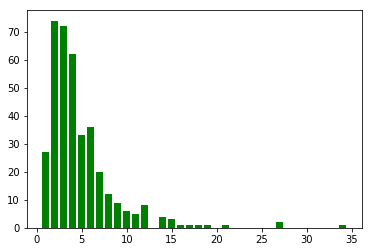

In [12]:
import matplotlib.pyplot as plt

dictionary = {1: 27, 34: 1, 3: 72, 4: 62, 5: 33, 6: 36, 7: 20, 8: 12, 9: 9, 10: 6, 11: 5, 
              12: 8, 2: 74, 14: 4, 15: 3, 16: 1, 17: 1, 18: 1, 19: 1, 21: 1, 27: 2}
plt.bar(list(dictionary.keys()), dictionary.values(), color='g')
plt.show()

In [ ]:
import matplotlib.pylab as plt

lists = sorted(genomes_len.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [135]:
import random
random.seed(a=25)
keys = list(genomes_len.keys())
s = set(random.sample(keys, len(genomes_len)//2))

#random.sample(population, k)

In [136]:
test={}
train={}
for i in genomes_len:
    if i in s:
        train[i] = genomes_len[i]
    else:
        test[i] = genomes_len[i]

In [137]:
print(len(test))
print(len(train))

5266
5266


In [66]:
#1. Get apriory distribution of length from input (refseq_test)
#Build a priori (uniform) probability distribution from the RefSeq viral database (refseq_test)

In [120]:
apriori = [1/len(train)]*len(train)

In [121]:
print(apriori[:10])

[0.00018989745537409798, 0.00018989745537409798, 0.00018989745537409798, 0.00018989745537409798, 0.00018989745537409798, 0.00018989745537409798, 0.00018989745537409798, 0.00018989745537409798, 0.00018989745537409798, 0.00018989745537409798]


In [74]:
#2. From genes -> lengths + small E for other viruses from refseq_test (pseudocounts)
#Predict genes and proteins in the viral contig using Prodigal (Hyatt et al, 2010).
#Blast predicted proteins on the proteins from RefSeq viruses (e-value=..., query coverage = …, # of top hits = ...)
#For each gene blast hits get the set of the corresponding viruses and build corresponding probability distribution


In [118]:
print(len(virus_hits))

3156
